### This Notebook processes the Metadata file and writes a new CSV file.

In [62]:
import pandas as pd
import numpy as np
import os

In [63]:
# checks if the processed folder exists and if not creates it
path =  '../data/processed/'
directory = os.path.dirname(path)
if not os.path.exists(directory):
    os.makedirs(directory)

In [64]:
#import table from tab file
dataframe = pd.read_csv('../data/HAM10000_metadata', delimiter=',')


In [65]:
#change endings of image_id to .jpg
dataframe['image_id'] = dataframe['image_id'].apply(lambda x: x + '.jpg')

In [66]:
#pool mel,bcc,akiec into skin cancer category in new column dx_binary
dataframe['dx_binary'] = np.where(dataframe['dx'].isin(['mel','bcc','akiec']), 'skin_cancer', 'not_skin_cancer')

dataframe['dx_tertiary'] = np.where(dataframe['dx_binary'] == 'skin_cancer', 'malignant', np.where(dataframe['dx'].isin(['bkl', 'vasc', 'df']), 'non-neoplastic', 'benign'))

In [67]:
#impute missing values in age column with median
dataframe['age'].fillna(dataframe['age'].median(), inplace=True)

In [68]:
#save as csv
dataframe.to_csv('../data/processed/Metadata_processed.csv', index=False)

# EDA -  HAM10000 - Metadata

## 1 Importing Libraries

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## 2 Importing Data

In [155]:
#import table from tab file
dataframe = pd.read_csv('../data/HAM10000_metadata', delimiter=',')
# load processed metadata
processed_dataframe = pd.read_csv('../data/processed/Metadata_processed.csv')

## 3 Data Exploration

### Context of raw features and their values

Ham10000_metadata consists of 8 features.
1. **lesion_id** - unique id per lesion
2. **image_id** - unique id per image taken of lesion
3. **dx** contains diagnosis with the following values
* "bkl" - benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
* "nv" - melanocytic nevi (normal moles)
* "df" - dermatofibroma (small scar after insect bite etc.)
* "vasc" - vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)
* "mel" = melanoma (Skin cancer 1)
* "bcc" = basal cell carcinoma (Skin cancer 2)
* "akiec" = actinic keratoses and intraepithelial carcinoma / Bowen's disease (Skin cancer 3)
4. **dx_type** diagnosis confirmed by
* "histo" - through histopathology
* "consensus" - expert consensus
* "confocal" - in-vivo confocal microscopy
* "follow_up" - follow-up examination
5. **age** of patients
6. **sex** of patients
* "male"
* "female"
* "unknown"
    
7. **localization** of the lesion
* "scalp"
* "ear"
* "face"
* "back"
* "trunk"
* "chest"
* "abdomen"
* "genital"
* "neck"
* "hand"
* "foot"
* "acral"
* "lower extremity"
* "upper extremnity"
* "unknown"
    
8. **dataset** source of observation
* "vidir_modern"
* "rosendahl"
* "vienna_dias"
* "vidir_molemax"

### Quick first check

In [156]:
def count_column_types(df: pd.DataFrame) -> dict[str, int]:
    # Count the number of columns of each type in a DataFrame
    dtypes: pd.Series = df.dtypes
    return {
        'text': (dtypes == 'object').sum(),
        'categorical': (dtypes == 'category').sum(),
        'numerical': dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x)).sum()
    }

In [157]:
print("HAM10000 - metadata:")
print("There are", dataframe.shape[1], "features with", dataframe.shape[0],"observations.")
print("---------------------------------")
print("Count of textbased features:", count_column_types(dataframe)["text"])
print("Count of categorical features:", count_column_types(dataframe)["categorical"])
print("Count of numerical features:", count_column_types(dataframe)["numerical"])
print("---------------------------------")
print("Number of duplicated rows:", dataframe.duplicated().sum())
print("Number of missing values:", dataframe.isnull().sum().sum())

HAM10000 - metadata:
There are 8 features with 10015 observations.
---------------------------------
Count of textbased features: 7
Count of categorical features: 0
Count of numerical features: 1
---------------------------------
Number of duplicated rows: 0
Number of missing values: 57


Quick look at the table of the raw dataframe.

In [158]:
# show first 10 rows
dataframe.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,vidir_modern


In [159]:
# show last 10 rows
dataframe.tail(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
10005,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face,rosendahl
10006,HAM_0004034,ISIC_0024948,akiec,histo,55.0,female,face,rosendahl
10007,HAM_0001565,ISIC_0028619,akiec,histo,60.0,female,face,vidir_modern
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,vidir_modern
10009,HAM_0005705,ISIC_0031430,akiec,histo,75.0,female,lower extremity,vidir_modern
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern


### 3.1 Descriptive Statistics - Tendency and measuring

In the preprocessed raw dataframe we have 8 features:  
* lesion_id,
* image_id
* dx
* dx_type
* age
* sex
* localization
* dataset

#### lesion_id

Unique Values, Missing Values

In [160]:
# Analyze feature "lesion_id"
print("Number of unique values in feature 'lesion_id':", dataframe["lesion_id"].nunique())
print("Relative number of unique values in feature 'lesion_id':", round(dataframe["lesion_id"].nunique()/dataframe.shape[0]*100), "%")
print("Number of missing values in feature 'lesion_id':", dataframe["lesion_id"].isnull().sum())

Number of unique values in feature 'lesion_id': 7470
Relative number of unique values in feature 'lesion_id': 75 %
Number of missing values in feature 'lesion_id': 0


Sum of lesion_id with more than one image

In [161]:
lesions_more_than_one_image = dataframe[dataframe["lesion_id"].map(dataframe["lesion_id"].value_counts()) > 1]
print("Sum of lesion_ids with more than one image taken:", lesions_more_than_one_image[['lesion_id']].nunique()[0])

Sum of lesion_ids with more than one image taken: 1956


There are lesion_ids that come with more than one image. It is assumed that these photos of a lesion_id were taken multiple times to achieve better image quality.

#### image_id

Unique Values, Missing Values

In [162]:
# Analyze feature "image_id"
print("Number of unique values in feature 'image_id':", dataframe["image_id"].nunique())
print("Relative number of unique values in feature 'image_id':", round(dataframe["image_id"].nunique()/dataframe.shape[0]*100), "%")
print("Number of missing values in feature 'image_id':", dataframe["image_id"].isnull().sum())

Number of unique values in feature 'image_id': 10015
Relative number of unique values in feature 'image_id': 100 %
Number of missing values in feature 'image_id': 0


Sum of image_id with more than one lesion:

In [163]:
# check if there are image_ids with more than one lesion_id
image_ids_more_than_one_lesion = dataframe[dataframe["image_id"].map(dataframe["image_id"].value_counts()) > 1]
print("Sum of image_ids with more than one lesion:", image_ids_more_than_one_lesion[['image_id']].nunique()[0])

Sum of image_ids with more than one lesion: 0


So it looks like the image_id is a unique key.

#### dx

Unique Values, Missing Values

In [164]:
# Analyze feature "dx"
print("Number of unique values in feature 'dx':", dataframe["dx"].nunique())
print("Number of missing values in feature 'dx':", dataframe["dx"].isnull().sum())

Number of unique values in feature 'dx': 7
Number of missing values in feature 'dx': 0


Countplot diagnoses (dx).

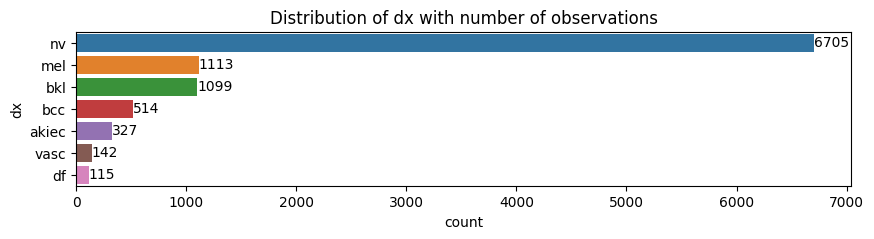

In [165]:
plt.figure(figsize=(10, 2))
ax = sns.countplot(y="dx", data=dataframe, order=dataframe['dx'].value_counts().index)
plt.title("Distribution of dx with number of observations")

if hasattr(ax, 'patches'):  # Ensure ax has the 'patches' attribute
    for p in ax.patches:
        ax.text(p.get_width(), p.get_y() + p.get_height()/2, 
                f'{int(p.get_width())}', 
                va='center')

plt.show()

#### dx_type

Unique Values, Missing Values

In [166]:
# Analyze feature "dx_type"
print("Number of unique values in feature 'dx_type':", dataframe["dx_type"].nunique())
print("Number of missing values in feature 'dx_type':", dataframe["dx_type"].isnull().sum())

Number of unique values in feature 'dx_type': 4
Number of missing values in feature 'dx_type': 0


Countplot kinds of diagnosis.

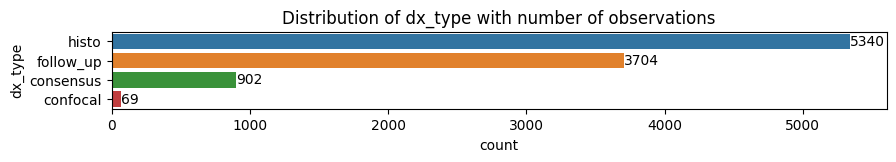

In [167]:
plt.figure(figsize=(10, 1))
ax = sns.countplot(y="dx_type", data=dataframe, order=dataframe['dx_type'].value_counts().index)
plt.title("Distribution of dx_type with number of observations")

if hasattr(ax, 'patches'):  # Ensure ax has the 'patches' attribute
    for p in ax.patches:
        ax.text(p.get_width(), p.get_y() + p.get_height()/2, 
                f'{int(p.get_width())}', 
                va='center')

plt.show()

#### age

Unique Values, Missing Values

In [168]:
# Analyze the feature "age"
print("Number of unique values in feature 'age':", dataframe["age"].nunique())
print("Number of missing values in feature 'age':", dataframe["age"].isnull().sum())

Number of unique values in feature 'age': 18
Number of missing values in feature 'age': 57


Text(0.5, 1.0, 'Distribution of dx with missing age')

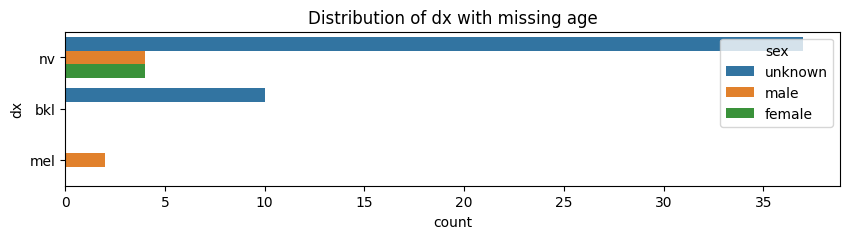

In [169]:
missing_ages = dataframe[dataframe["age"].isnull()]

# plot missing ages regarding dx and sex
plt.figure(figsize=(10, 2))
ax = sns.countplot(y="dx", data=missing_ages, hue='sex', order=missing_ages['dx'].value_counts().index)
plt.title("Distribution of dx with missing age")

Mean, standard deviation, range

In [170]:
# Describe the feature "age"
dataframe[["age"]].describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


Histogram of age

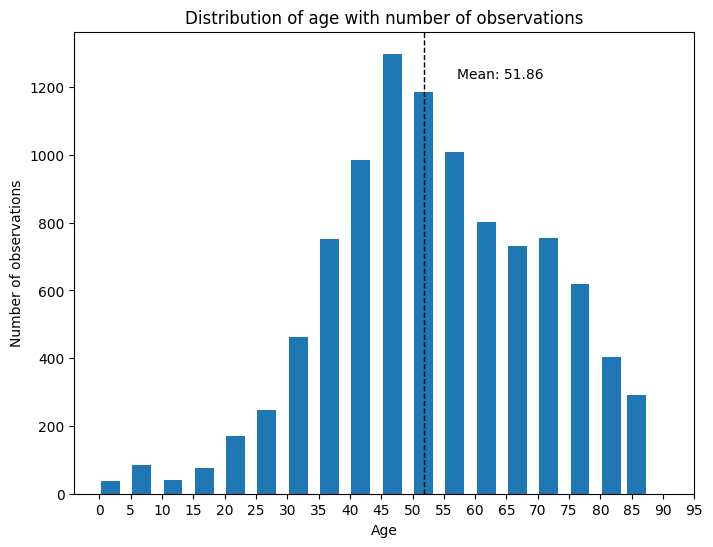

In [171]:
#plot histogram of age
plt.figure(figsize=(8, 6))
plt.hist(dataframe["age"], bins=85, width=3, rwidth=0.5)
plt.title("Distribution of age with number of observations")
plt.xlabel("Age")
plt.ylabel("Number of observations")
plt.xticks(np.arange(0, 100, step=5))
#plot mean with line and label and show value
plt.axvline(dataframe["age"].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(dataframe["age"].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(dataframe["age"].mean()))
plt.show()


Boxplot of age

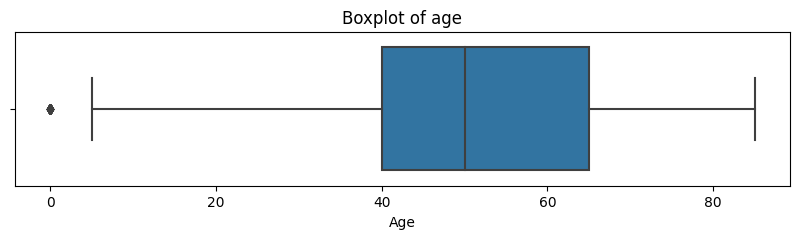

In [172]:
# plot boxplot of age
plt.figure(figsize=(10, 2))
sns.boxplot(x=dataframe["age"])
plt.title("Boxplot of age")
plt.xlabel("Age")
plt.show()


#### sex

Unique Values, Missing Values

In [173]:
#analyze the feature sex
print("Number of unique values in feature 'sex':", dataframe["sex"].nunique())
print("Number of missing values in feature 'sex':", dataframe["sex"].isnull().sum())

Number of unique values in feature 'sex': 3
Number of missing values in feature 'sex': 0


Number of unknown sex: 57


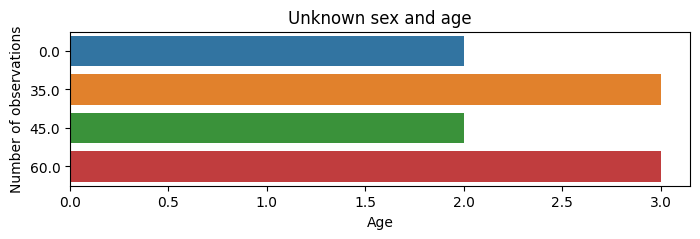

In [174]:
#count 'unknown' values in sex and print
unknown_sex = dataframe.query("sex == 'unknown'")
print("Number of unknown sex:" , unknown_sex.shape[0])

#plot unknown_sex regarding age
plt.figure(figsize=(8, 2))
sns.countplot(data=unknown_sex, y="age")
plt.title("Unknown sex and age")
plt.xlabel("Age")
plt.ylabel("Number of observations")
plt.show()



Countplot of sex

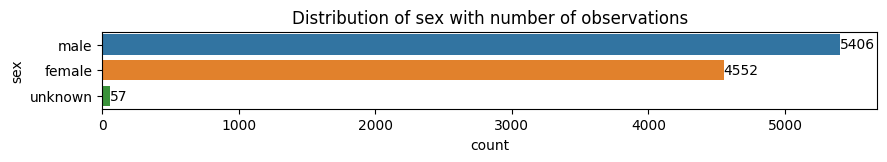

In [175]:
plt.figure(figsize=(10, 1))
ax = sns.countplot(y="sex", data=dataframe, order=dataframe['sex'].value_counts().index)
plt.title("Distribution of sex with number of observations")

if hasattr(ax, 'patches'):  # Ensure ax has the 'patches' attribute
    for p in ax.patches:
        ax.text(p.get_width(), p.get_y() + p.get_height()/2, 
                f'{int(p.get_width())}', 
                va='center')

plt.show()

#### localization

Unique Values, Missing Values

In [176]:
# Analyze the feature "age"
print("Number of unique values in feature 'localization':", dataframe["localization"].nunique())
print("Number of missing values in feature 'localization':", dataframe["localization"].isnull().sum())

Number of unique values in feature 'localization': 15
Number of missing values in feature 'localization': 0


Countplot of localization

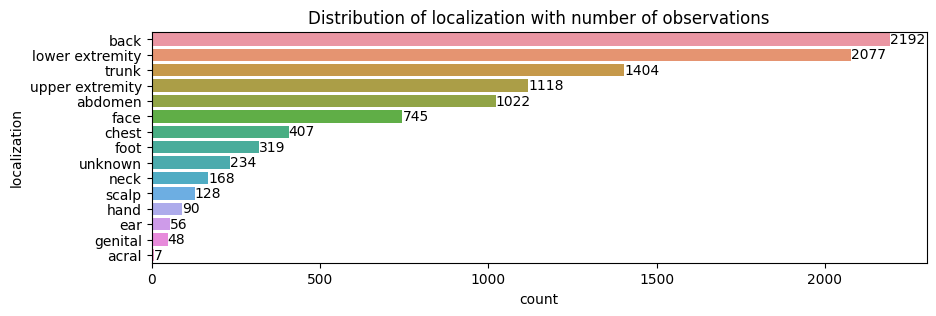

In [177]:
plt.figure(figsize=(10, 3))
ax = sns.countplot(y="localization", data=dataframe, order=dataframe['localization'].value_counts().index)
plt.title("Distribution of localization with number of observations")

if hasattr(ax, 'patches'):  # Ensure ax has the 'patches' attribute
    for p in ax.patches:
        ax.text(p.get_width(), p.get_y() + p.get_height()/2, 
                f'{int(p.get_width())}', 
                va='center')

plt.show()

#### dataset

Unique Values, Missing Values

In [178]:
# Analyze the feature "dataset"
print("Number of unique values in feature 'dataset':", dataframe["dataset"].nunique())
print("Number of missing values in feature 'dataset':", dataframe["dataset"].isnull().sum())

Number of unique values in feature 'dataset': 4
Number of missing values in feature 'dataset': 0


Countplot of dataset

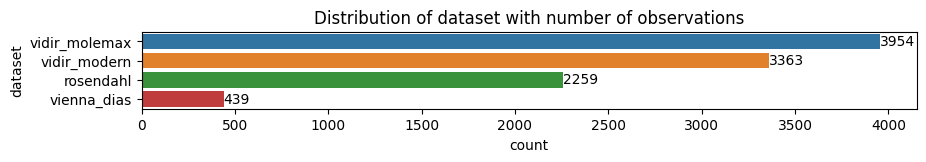

In [179]:
plt.figure(figsize=(10, 1))
ax = sns.countplot(y="dataset", data=dataframe, order=dataframe['dataset'].value_counts().index)
plt.title("Distribution of dataset with number of observations")

if hasattr(ax, 'patches'):  # Ensure ax has the 'patches' attribute
    for p in ax.patches:
        ax.text(p.get_width(), p.get_y() + p.get_height()/2, 
                f'{int(p.get_width())}', 
                va='center')

plt.show()

### 3.2 Confronting Emerging Issues - Round 1

#### Problem 2: Missing Values in Age column - We can either drop the rows with missing values or impute the missing values with mean/median/mode.

In [180]:
# show range of age
dataframe.age.describe()

count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

#### Solution Problem 2:

In [181]:
# replace NaN with the mean of the age column
#df_filled = dataframe['age'].fillna((dataframe['age'].mean()), inplace=True)

solve later

### 3.3 Relational Statistics

In [182]:
# define features as categorical
dataframe['dx'] = dataframe['dx'].astype('category')
dataframe['dx_type'] = dataframe['dx_type'].astype('category')
dataframe['sex'] = dataframe['sex'].astype('category')
dataframe['localization'] = dataframe['localization'].astype('category')
dataframe['dataset'] = dataframe['dataset'].astype('category')

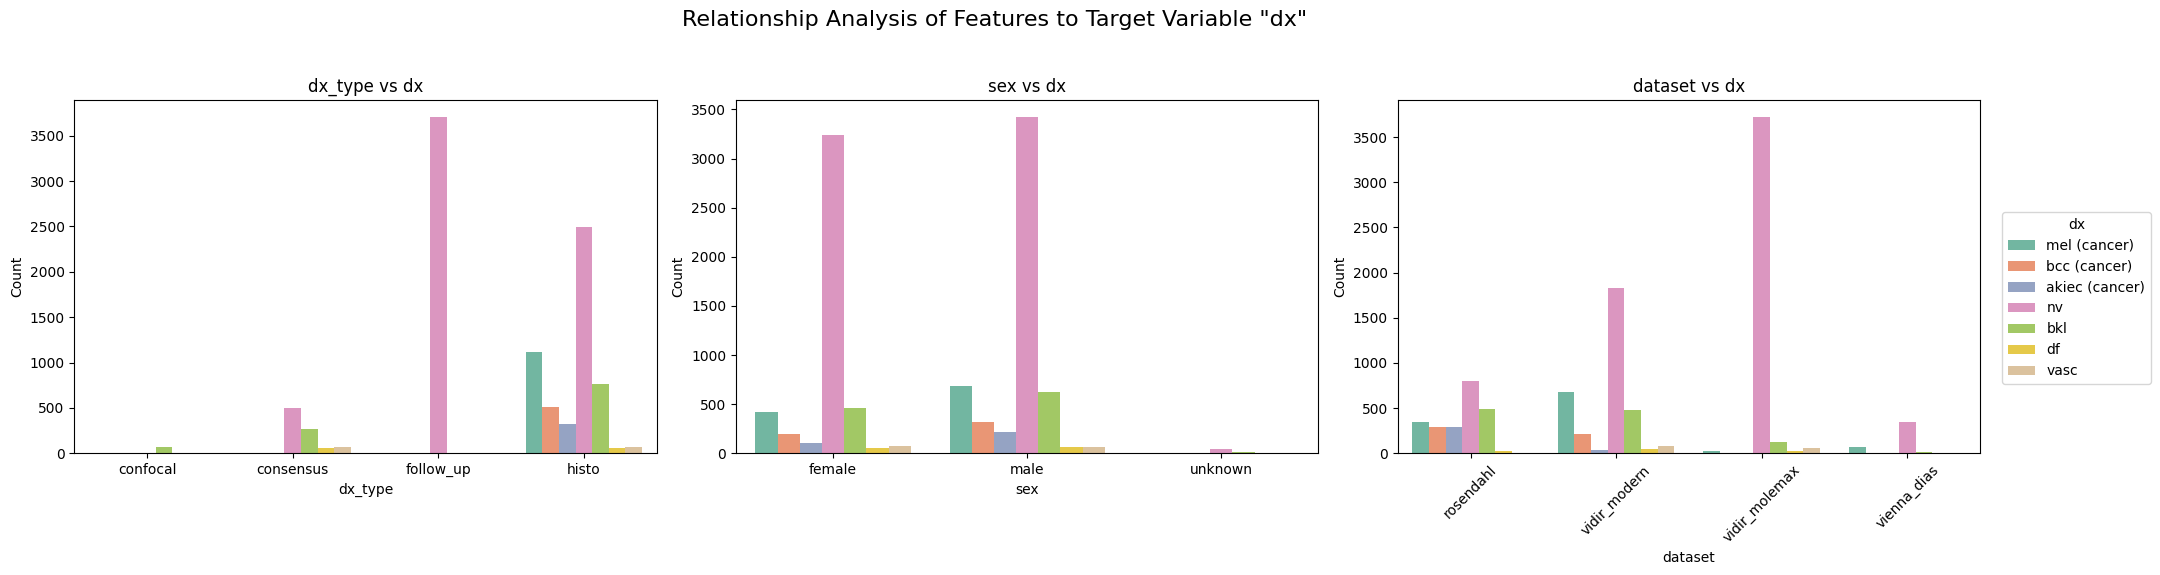

In [183]:
data = dataframe
order_categories = ['mel', 'bcc', 'akiec', 'nv', 'bkl', 'df', 'vasc']

# Set up the figure and axes for the three plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('Relationship Analysis of Features to Target Variable "dx"', fontsize=16)

# Plot dx_type vs dx
sns.countplot(data=data, x='dx_type', hue='dx', ax=axes[0], palette="Set2", hue_order=order_categories)
axes[0].set_title('dx_type vs dx')
axes[0].set_ylabel('Count')
axes[0].get_legend().remove()  # Remove individual legend

# Plot sex vs dx
sns.countplot(data=data, x='sex', hue='dx', ax=axes[1], palette="Set2", hue_order=order_categories)
axes[1].set_title('sex vs dx')
axes[1].set_ylabel('Count')
axes[1].get_legend().remove()  # Remove individual legend

# Plot dataset vs dx
sns.countplot(data=data, x='dataset', hue='dx', ax=axes[2], palette="Set2", hue_order=order_categories)
axes[2].set_title('dataset vs dx')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)
axes[2].get_legend().remove()  # Remove individual legend

# Add a common legend outside the grid
handles, labels = axes[2].get_legend_handles_labels()
labels = ['mel (cancer)', 'bcc (cancer)', 'akiec (cancer)', 'nv', 'bkl', 'df', 'vasc']
fig.legend(handles=handles, labels=labels, title='dx', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



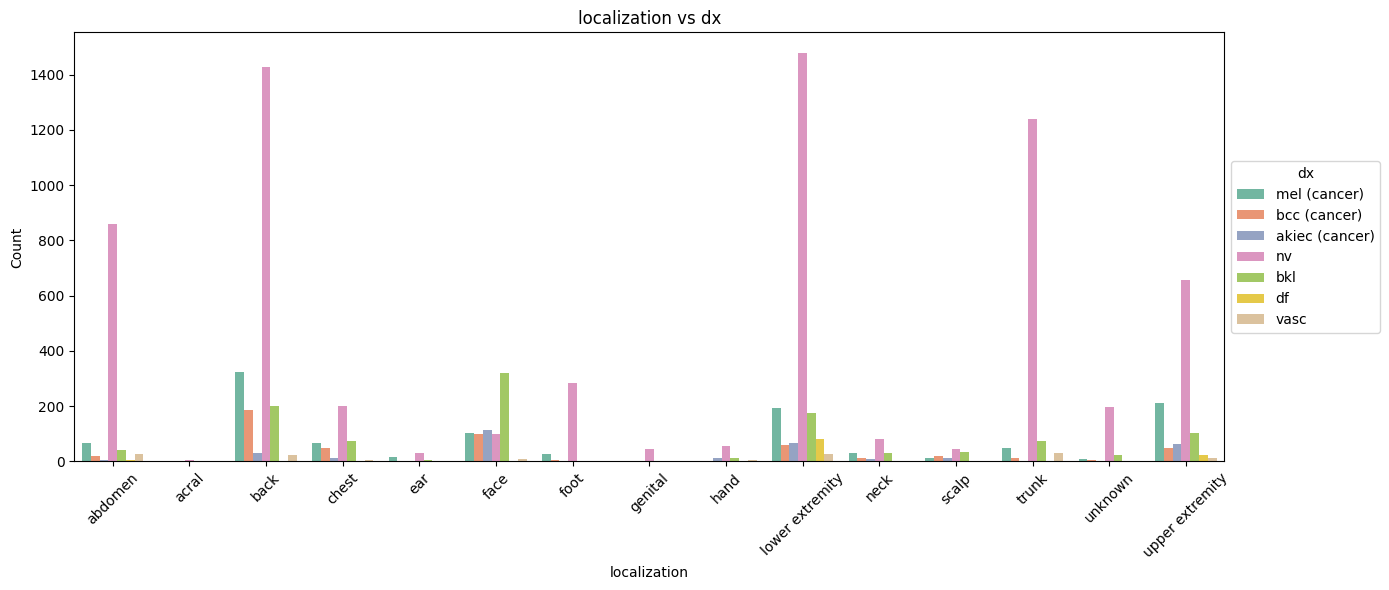

In [199]:
data = dataframe
order_categories = ['mel', 'bcc', 'akiec', 'nv', 'bkl', 'df', 'vasc']

# Plot for localization vs dx with the legend outside the grid
plt.figure(figsize=(14, 6))
ax_local = sns.countplot(data=data, x='localization', hue='dx', palette="Set2", hue_order=order_categories)
plt.title('localization vs dx')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add a legend outside the grid
handles, labels = ax_local.get_legend_handles_labels()
labels = ['mel (cancer)', 'bcc (cancer)', 'akiec (cancer)', 'nv', 'bkl', 'df', 'vasc']
plt.legend(handles=handles, labels=labels, title='dx', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

#### Contingency: dx vs dx_type

The cross table displays the relationship between "dx" and "dx_type". For some categories of "dx", there is only one type of "dx_type" (e.g., "akiec" and "histo").

In [184]:
# Create a contingency table for dx and dx_type
contingency_dx_type = pd.crosstab(dataframe['dx'], dataframe['dx_type'])

contingency_dx_type



dx_type,confocal,consensus,follow_up,histo
dx,,,,
akiec,0,0,0,327
bcc,0,0,0,514
bkl,69,264,0,766
df,0,60,0,55
mel,0,0,0,1113
nv,0,503,3704,2498
vasc,0,75,0,67


#### Contingency dx vs sex

The cross table shows the distribution of skin lesion types ("dx") in relation to gender. For example, there are 106 cases of "akiec" in women and 221 cases in men.

In [185]:
# Create a contingency table for dx and sex
contingency_sex = pd.crosstab(data['dx'], data['sex'])

contingency_sex

sex,female,male,unknown
dx,,,
akiec,106,221,0
bcc,197,317,0
bkl,463,626,10
df,52,63,0
mel,424,689,0
nv,3237,3421,47
vasc,73,69,0


#### Contingency dx vs localization

The cross table shows the distribution of skin lesion types ("dx") in relation to their localization. For example, there are 65 cases of "akiec" located on the lower extremities and 113 cases of "akiec" located on the face.

In [186]:
# Create a contingency table for dx and localization
contingency_localization = pd.crosstab(data['dx'], data['localization'])

contingency_localization

localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity
dx,,,,,,,,,,,,,,,
akiec,5,0,29,12,3,113,0,0,13,65,10,14,1,0,62
bcc,18,0,186,47,0,101,4,0,2,58,14,19,11,5,49
bkl,42,0,202,74,6,319,1,2,14,174,31,34,73,23,104
df,4,0,2,0,0,0,2,1,0,82,0,0,0,0,24
mel,66,0,324,68,17,104,28,0,1,192,29,14,47,10,213
nv,860,7,1427,200,30,100,284,45,55,1479,81,45,1241,196,655
vasc,27,0,22,6,0,8,0,0,5,27,3,2,31,0,11


#### Contingency dx vs dataset

The cross table shows the distribution of skin lesion types ("dx") based on the dataset from which they originate. For example, there are 295 cases of "akiec" from the "rosendahl" dataset and 32 cases from the "vidir_modern" dataset.

In [187]:
# Create a contingency table for dx and dataset
contingency_dataset = pd.crosstab(data['dx'], data['dataset'])

contingency_dataset

dataset,rosendahl,vidir_modern,vidir_molemax,vienna_dias
dx,,,,
akiec,295,32,0,0
bcc,296,211,2,5
bkl,490,475,124,10
df,30,51,30,4
mel,342,680,24,67
nv,803,1832,3720,350
vasc,3,82,54,3


#### Mean Age per Diagnosis

The bar chart shows the average age for each category of "dx". For instance, individuals with the diagnosis "df" (Dermatofibroma) have an average age that is higher than those with the diagnosis "mel" (Melanoma).

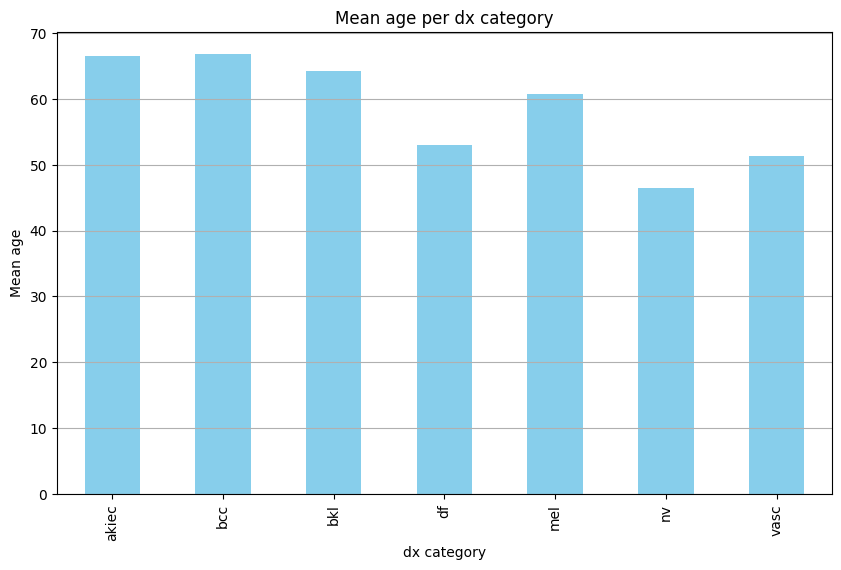

In [188]:
# Group by dx and calculate mean age
mean_age_per_dx = data.groupby('dx')['age'].mean()

# Plot the mean age for each dx category
plt.figure(figsize=(10, 6))
mean_age_per_dx.plot(kind='bar', color='skyblue')
plt.title('Mean age per dx category')
plt.ylabel('Mean age')
plt.xlabel('dx category')
plt.grid(axis='y')
plt.show()

#### Chi2-Test

Categorical data can be correlated with the target variable using the Chi-Squared Test. This test checks if there is a significant association between two categorical variables. A significant test value suggests that the variables are not independent of each other.

In the case where the target variable ("dx") and a categorical feature are correlated, we can use the p-value of the Chi-Squared Test to determine if the association is significant.

In [207]:
from scipy.stats import chi2_contingency

# List of categorical features to test
features_to_test = ['dx_type', 'sex', 'localization', 'dataset']

# Store p-values and test statistics
p_values = {}
test_statistics = {}

# Perform chi2 test for each feature
for feature in features_to_test:
    contingency_table = pd.crosstab(data['dx'], data[feature])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    p_values[feature] = p
    test_statistics[feature] = chi2

print("p-Values: ", p_values)
print("Test Statistics:", test_statistics)
print("Significance level: 0.05")
print("")
print("Conclusion:")
print("The null hypothesis is rejected if the p-value is less than the significance level.")
print("The null hypothesis is that the two categorical variables (feature vs dx) are independent.")
print("The alternative hypothesis is that the two categorical variables (feature vs dx) are dependent.")
print("")
print("The p-values are all less than the significance level.")
print("Therefore, the null hypothesis is rejected for all features.")
print("The alternative hypothesis is accepted for all features.")


p-Values:  {'dx_type': 0.0, 'sex': 2.4464388098587195e-17, 'localization': 0.0, 'dataset': 0.0}
Test Statistics: {'dx_type': 4576.809761851322, 'sex': 106.90381271641068, 'localization': 2821.9101978213816, 'dataset': 3484.0619808375}
Significance level: 0.05

Conclusion:
The null hypothesis is rejected if the p-value is less than the significance level.
The null hypothesis is that the two categorical variables (feature vs dx) are independent.
The alternative hypothesis is that the two categorical variables (feature vs dx) are dependent.

The p-values are all less than the significance level.
Therefore, the null hypothesis is rejected for all features.
The alternative hypothesis is accepted for all features.


The bar chart displays the Chi2 test statistics for the various features in relation to the target variable "dx". A higher value of the test statistic suggests a stronger association between the feature and the target variable. As you can see, all features have a significant association with "dx", with "dx_type" showing the strongest and "sex" showing the weakest (but still significant) association.

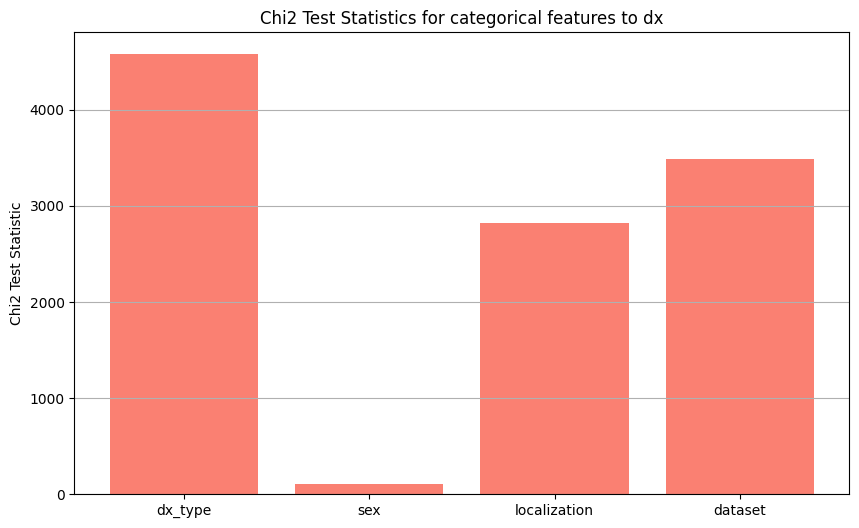

In [190]:
# Visualize the chi2 test statistics for each feature
plt.figure(figsize=(10, 6))
plt.bar(test_statistics.keys(), test_statistics.values(), color='salmon')
plt.ylabel('Chi2 Test Statistic')
plt.title('Chi2 Test Statistics for categorical features to dx')
plt.grid(axis='y')
plt.show()

#### dx and age

Boxplot age and dx

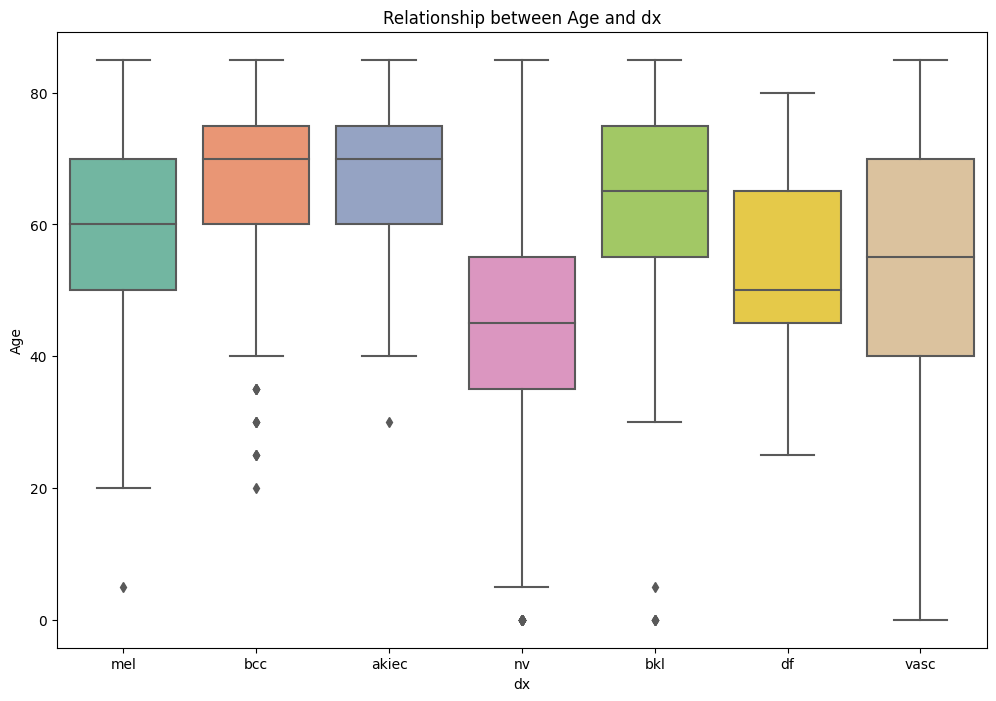

In [191]:
data = dataframe

# Boxplot to visualize the relationship between 'age' and 'dx'
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='dx', y='age', palette="Set2", order=order_categories)
plt.title('Relationship between Age and dx')
plt.ylabel('Age')
plt.xlabel('dx')
plt.show()

Based on the boxplot visualizing the relationship between 'age' and 'dx' (excluding 'nv'), we can make the following observations:

1) Spread and Central Tendency:

    The median age for conditions like 'akiec' seems to be higher compared to other conditions, suggesting that 'akiec' might be more prevalent among older individuals.
    'mel' and 'bcc' also show a higher median age compared to some other conditions, but not as high as 'akiec'.

2) Variability:

    The age distribution for 'nv' (which was excluded in the later analysis) was broader, meaning it affects a wider age range of people.
    The interquartile range (IQR, represented by the box's height) for conditions like 'akiec' is narrower, suggesting that the ages of patients with this condition are more concentrated around the median.

3) Outliers:

    There may be some outliers (points outside the whiskers of the boxplot) for some conditions, indicating ages that are unusually high or low for those conditions.

4) Comparisons:

    By comparing the boxes' positions and spreads, we can infer which conditions are more prevalent at younger or older ages. For instance, 'akiec' and 'mel' tend to be associated with older ages compared to conditions like 'bkl' or 'df'.

In summary, the boxplot provides insights into the age distributions associated with each 'dx' category. It suggests that certain skin conditions may be more prevalent or diagnosed at specific age ranges. The exact age distributions and their implications would need to be further investigated and validated with domain-specific knowledge and larger datasets.

**A more detailed look at age, localization and cancer-related diagnoses:**

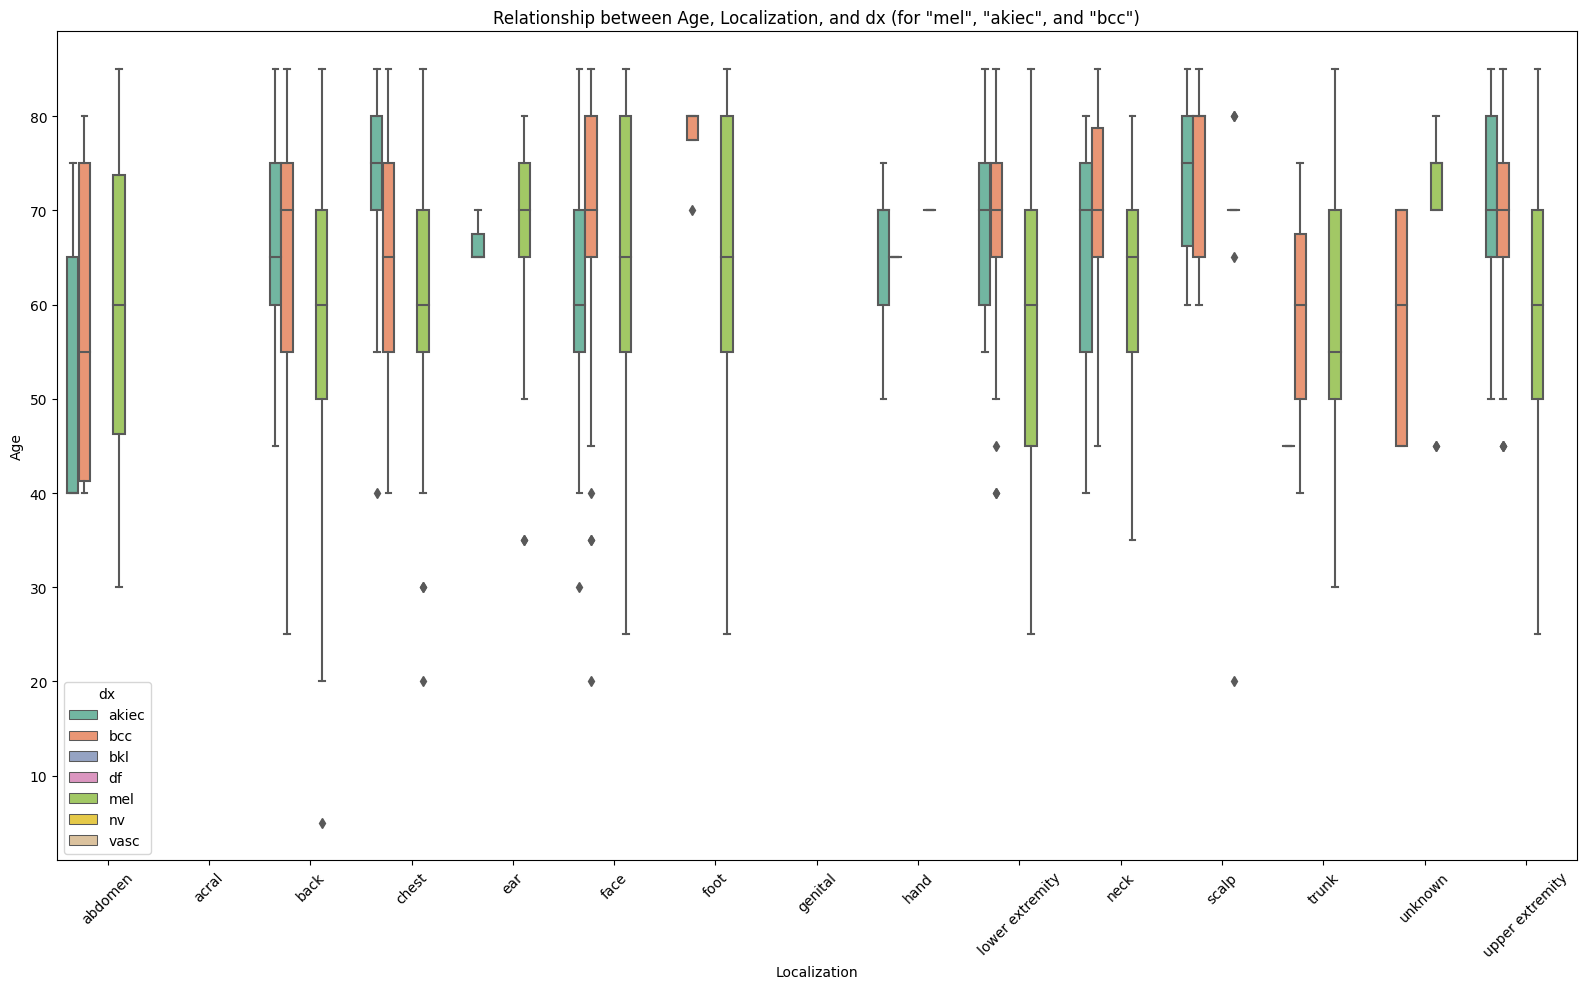

In [192]:
data = dataframe

# Filter the dataset for rows where 'dx' is 'mel', 'akiec', or 'bcc'
filtered_data = data[data['dx'].isin(['mel', 'akiec', 'bcc'])]

# Boxplot to visualize the relationship between 'age', 'localization', and 'dx'
plt.figure(figsize=(16, 10))
sns.boxplot(data=filtered_data, x='localization', y='age', hue='dx', palette="Set2")
plt.title('Relationship between Age, Localization, and dx (for "mel", "akiec", and "bcc")')
plt.ylabel('Age')
plt.xlabel('Localization')
plt.legend(title='dx')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.4 Risk Ratio

#### Localization and Melanoma (skin cancer 3)

The bar chart below shows the risk ratio for "mel" in relation to the various "localization" categories, with "abdomen" serving as the reference group.
A risk ratio greater than 1 means that the risk of having an actinic carcinoma in this specific "localization" category is higher than in the "abdomen".

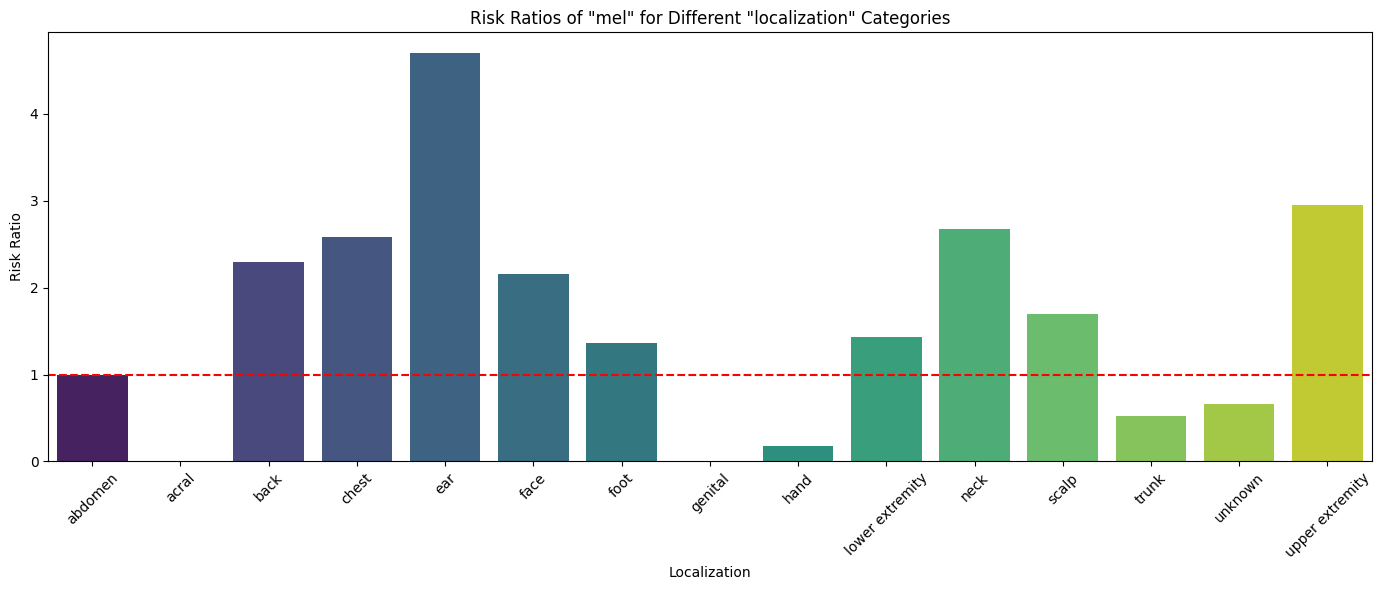

In [194]:
data = dataframe

# Create a binary column for the event "mel"
data['mel_event'] = (data['dx'] == 'mel').astype(int)

# Calculate the risk for each localization category
risk_per_localization = data.groupby('localization')['mel_event'].mean()

# Choose "abdomen" as the reference group
reference_risk = risk_per_localization['abdomen']

# Calculate the risk ratio for each localization category
risk_ratios = risk_per_localization / reference_risk

# Visualize the risk ratios
plt.figure(figsize=(14, 6))
sns.barplot(x=risk_ratios.index, y=risk_ratios.values, palette="viridis")
plt.title('Risk Ratios of "mel" for Different "localization" Categories')
plt.ylabel('Risk Ratio')
plt.xlabel('Localization')
plt.axhline(y=1, color='red', linestyle='--')  # Reference line for RR=1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Localization and basal cell carcinoma (skin cancer 2)

The bar chart below shows the risk ratio for "bcc" in relation to the various "localization" categories, with "abdomen" serving as the reference group.
As in the previous charts, a risk ratio greater than 1 means that the risk of having an actinic carcinoma in this specific "localization" category is higher than in the "abdomen".

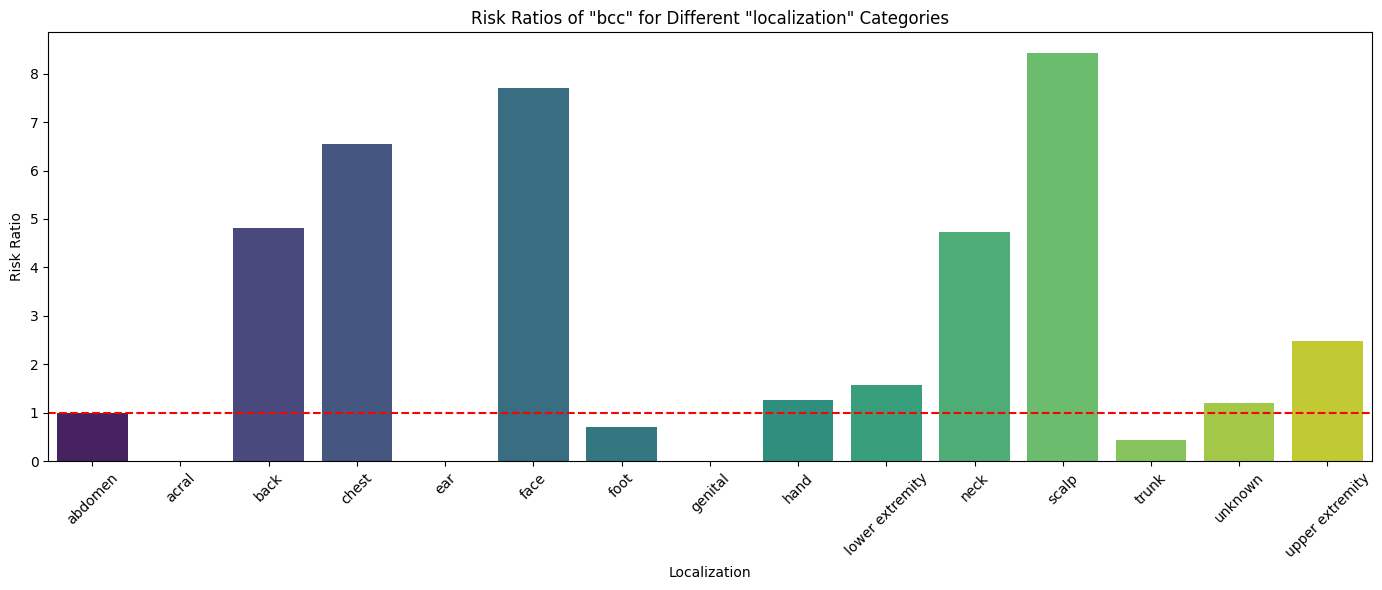

In [195]:
data = dataframe

# Create a binary column for the event "bcc"
data['bcc_event'] = (data['dx'] == 'bcc').astype(int)

# Calculate the risk for each localization category
risk_per_localization_bcc = data.groupby('localization')['bcc_event'].mean()

# Use "abdomen" as the reference group
reference_risk_bcc = risk_per_localization_bcc['abdomen']

# Calculate the risk ratio for each localization category
risk_ratios_bcc = risk_per_localization_bcc / reference_risk_bcc

# Visualize the risk ratios for bcc
plt.figure(figsize=(14, 6))
sns.barplot(x=risk_ratios_bcc.index, y=risk_ratios_bcc.values, palette="viridis")
plt.title('Risk Ratios of "bcc" for Different "localization" Categories')
plt.ylabel('Risk Ratio')
plt.xlabel('Localization')
plt.axhline(y=1, color='red', linestyle='--')  # Reference line for RR=1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Localization and actinic keratoses and intraepithelial carcinoma / Bowen's disease (skin cancer 3)

The bar chart below shows the risk ratio for "akiec" in relation to the various "localization" categories, with "abdomen" serving as the reference group.
As in the previous charts, a risk ratio greater than 1 means that the risk of having an actinic carcinoma in this specific "localization" category is higher than in the "abdomen".

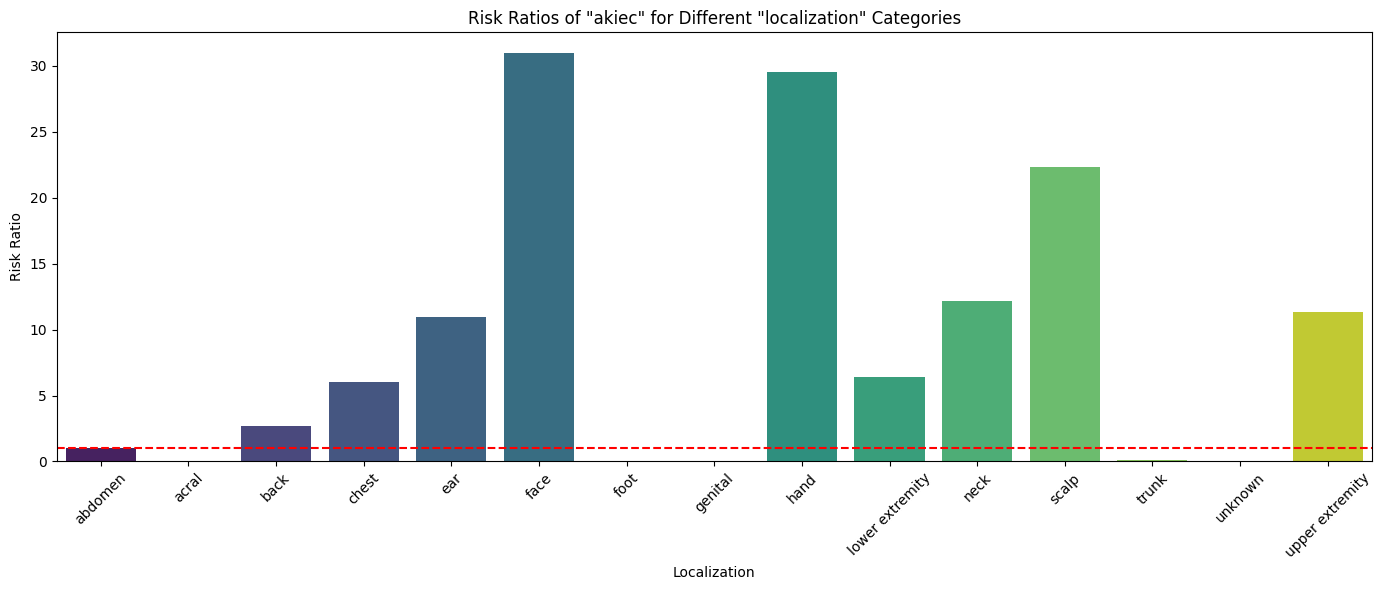

In [196]:
data = dataframe

# Create a binary column for the event "akiec"
data['akiec_event'] = (data['dx'] == 'akiec').astype(int)

# Calculate the risk for each localization category
risk_per_localization_akiec = data.groupby('localization')['akiec_event'].mean()

# Use "abdomen" as the reference group
reference_risk_akiec = risk_per_localization_akiec['abdomen']

# Calculate the risk ratio for each localization category
risk_ratios_akiec = risk_per_localization_akiec / reference_risk_akiec

# Visualize the risk ratios for akiec
plt.figure(figsize=(14, 6))
sns.barplot(x=risk_ratios_akiec.index, y=risk_ratios_akiec.values, palette="viridis")
plt.title('Risk Ratios of "akiec" for Different "localization" Categories')
plt.ylabel('Risk Ratio')
plt.xlabel('Localization')
plt.axhline(y=1, color='red', linestyle='--')  # Reference line for RR=1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4 Confronting Emerging Issues - Round 2

#### 1) Distribution of diagnosis

Target classifier is very imbalanced. We need to see if Tensorflow has problems with that. 
* Class weights - penalize the model for misclassifying minority class
* Data Augmentation - create more samples for minority class by multiple random transformations
* Resampling - create more samples for minority class by duplicating existing samples (SMOTE,variational autoencoders)
* Evaluation Metrics - Accuracy is not a good metric for imbalanced datasets. We can use F1 score, precision, recall, AUC etc.

Solutions: Subset of equal amount of images, anomaly detection, image augmentation

#### 2) Distribution of location of the lesion

In [197]:
dataframe.localization.unique()

['scalp', 'ear', 'face', 'back', 'trunk', ..., 'genital', 'neck', 'hand', 'foot', 'acral']
Length: 15
Categories (15, object): ['abdomen', 'acral', 'back', 'chest', ..., 'scalp', 'trunk', 'unknown', 'upper extremity']

Classes like trunk include chest,back,abdomen,genital and might overlap with upper extremity. We might need to decide where to classify these lesions. Maybe we can agglumerate all these classes into one class called trunk.

Maybe we can agglumerate some classes together like face and ear etc.


Contingency/ relation between cancerous / non-cancerous vs the location found

In [202]:
# relation between localization and type of lesion
# dropping nv because of the high number of entries
# Filter out rows where dx is 'nv'
# Filter out rows where dx is 'nv'
data_without_nv = data[data['dx'] != 'nv']

# Create a contingency table for 'localization' and 'dx'
contingency_table = pd.crosstab(data_without_nv['localization'], data_without_nv['dx'])

contingency_table


dx,akiec,bcc,bkl,df,mel,vasc
localization,,,,,,
abdomen,5,18,42,4,66,27
back,29,186,202,2,324,22
chest,12,47,74,0,68,6
ear,3,0,6,0,17,0
face,113,101,319,0,104,8
foot,0,4,1,2,28,0
genital,0,0,2,1,0,0
hand,13,2,14,0,1,5
lower extremity,65,58,174,82,192,27


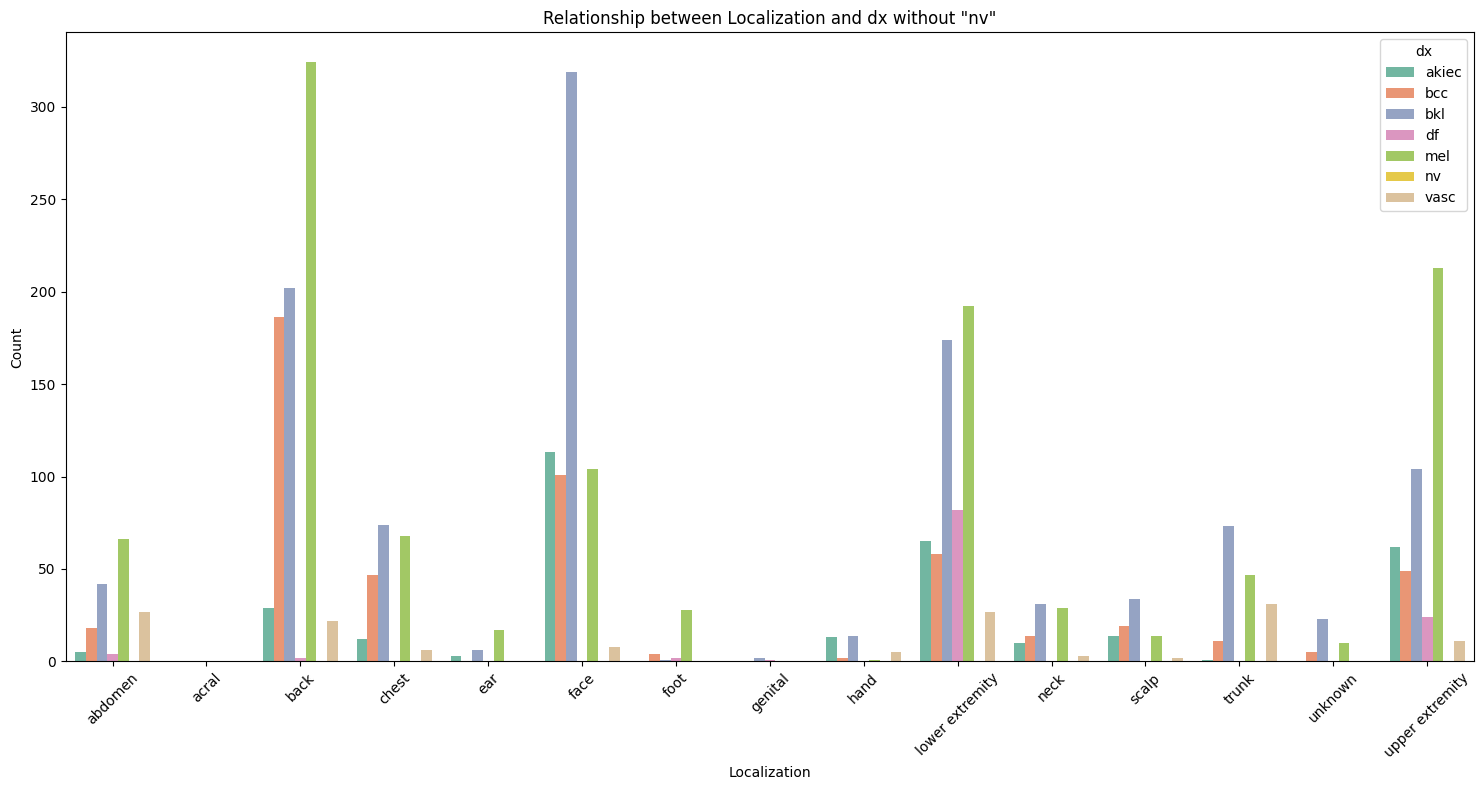

Chi-Squared Value: 3484.0619808375
P-Value: 0.0
The relationship between localization and dx (without nv) is statistically significant.


In [210]:
# Step 2: Visualization
plt.figure(figsize=(15, 8))
sns.countplot(data=data_without_nv, x='localization', hue='dx', palette="Set2")
plt.title('Relationship between Localization and dx without "nv"')
plt.ylabel('Count')
plt.xlabel('Localization')
plt.xticks(rotation=45)
plt.legend(title='dx')
plt.tight_layout()
plt.show()

# Step 3: Chi-Squared Test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Squared Value: {chi2}")
print(f"P-Value: {p}")
if p < 0.05:
    print("The relationship between localization and dx (without nv) is statistically significant.")
else:
    print("There's no statistically significant relationship between localization and dx (without nv).")

#### 3) Distribution of Age and Sex

#### 4) Distribution of type of ground truth

distribution between cancerous/ non cancerous
do lesion_id/image_id come up again in dx_type follow up

can think about making two classes the doctor's praxis or the laboratory(confocal/histo)

# Mod. Image Loader with Albumentation

Description: This notebook loads images from a directory, and handles imbalanced classes with down/re/upsampling and augmentation.

This notebook should be run from the top to the bottom, resulting in 3 files:

* `train_from_Metadata_processed.csv` - a csv file with the training data
* `validation_from_Metadata_processed.csv` - a csv file with the validation data
* `test_from_Metadata_processed.csv` - a csv file with the test data

These files encode the images with labels.


## Imports and inital setup

In [1]:
# Imports
import pandas as pd

from albumentations import (Compose, RandomCrop, Normalize, HorizontalFlip, Resize, RandomBrightnessContrast, CoarseDropout, GridDistortion, HueSaturationValue, GaussianBlur, Rotate, RandomResizedCrop)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os
import random
import sys

sys.path.append("..")
from helperfunctions import imagehelper as ih

SEED = 6932

MAX_SAMPLES_TRAIN = 650
MAX_SAMPLES_VAL = int(MAX_SAMPLES_TRAIN * 0.33)

# File path variables
# please make sure to use the correct path to the meta data file
FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_METADATA="./../data/processed/Metadata_processed.csv"
FILEPATH_OUTPUT = './../data/jpgs/' 

TARGET_LABEL="dx_tertiary"    # Needed for test train split
BALANCE_LABEL="dx"          # Needed for balancing the dataset
IMAGE_SIZE = (224, 224)     # Adapt to your model!

### Deleting all previously augmented images in advance

In [2]:
# Define the bash script as a string
bash_script = """
#!/bin/bash

output_folder="./../data/jpgs/" 

# Delete images with the "aug_" prefix
find "$output_folder" -type f -name "aug_*" -delete

echo "Deleted augmented images with 'aug_' prefix in $output_folder"
"""

# Save the bash script to a file
with open('delete_augmented_images.sh', 'w') as script_file:
    script_file.write(bash_script)

# Make the script executable
!chmod +x delete_augmented_images.sh

# Execute the script
!./delete_augmented_images.sh

# Delete the script
!rm delete_augmented_images.sh

Deleted augmented images with 'aug_' prefix in ./../data/jpgs/


### Loading the metadata file

In [3]:
# Read the metadata file
metadata = pd.read_csv(FILEPATH_METADATA)

# Concatenate the base directory with the image filename to add the full path
metadata['image_path'] = FILEPATH_JPGS + metadata['image_id']

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary,image_path
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0031633.jpg


# Splitting the data in train, validation and test sets

In [4]:
# Splitting the data into train, validation and test using train_test_split

# Split the data into two subsets: train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(metadata, test_size=0.2, stratify=metadata[BALANCE_LABEL], random_state=SEED)

# Split the temp data into validation and test sets (50% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[BALANCE_LABEL], random_state=SEED)

# resetting the index
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

display(
    train_df.shape,
    validation_df.shape,
    test_df.shape
)

(8012, 11)

(1001, 11)

(1002, 11)

In [5]:
# Showing the number of samples per BALANCE_LABEL in train, validation and test set
print("Samples per class in train set:")
print(train_df[BALANCE_LABEL].value_counts())
print(" ")
print("Samples per class in val set:")
print(validation_df[BALANCE_LABEL].value_counts())
print(" ")
print("Samples per class in test set:")
print(test_df[BALANCE_LABEL].value_counts())

Samples per class in train set:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
 
Samples per class in val set:
dx
nv       670
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64
 
Samples per class in test set:
dx
nv       671
mel      112
bkl      110
bcc       52
akiec     32
vasc      14
df        11
Name: count, dtype: int64


# Tackling Class imbalances in the training set

## Setting up the image data generator for augmentation

In [6]:
# Using albumentations to augment the data

datagen_augment = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    RandomResizedCrop(always_apply=False, p=0.5, scale=(0.75, 0.85), interpolation=0, height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
    # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    # GaussianBlur(blur_limit=(3, 7), p=0.5),
    # CoarseDropout(max_holes=12, min_height= 3 ,max_height=12,min_width=3, max_width=12, p=0.5),
])

## Preparing data for augmentation

In [7]:
def df_balancer_augmentation(df, datagen_augment, balance_label, max_samples, image_size, output_filepath, seed=42) -> pd.DataFrame:
    """
    This function takes a DataFrame and applies data augmentation to balance the classes.
    The function returns a new DataFrame with the augmented data.
    Args:
        df: DataFrame to be balanced
        datagen_augment: Augmentation generator
        balance_label: Column name of the column with the class labels which will be balanced
        max_samples: Maximum number of samples per class
        image_size: Size of the images
        output_filepath: Filepath to save the augmented images
    Returns:
        balanced_train_df: DataFrame with the augmented data
    """
    # print what function is going to do
    print(f"Balancing and augmenting data frame using label:{balance_label} to {max_samples} samples per class...\n")

    # Create separate DataFrames for every class in the given BALANCE_LABEL column

    class_dataframes = {}
    for class_label in df[balance_label].unique():
        class_dataframes[class_label] = df[df[balance_label] == class_label]
        # print(f"Class {class_label} has {class_dataframes[class_label].shape[0]} samples")

    # Initialize a dictionary to keep track of the number of augmented images per class
    class_augmentation_counts = {class_label: 0 for class_label in class_dataframes.keys()}

    # Create a list to store newly generated DataFrames for each class
    augmented_dataframes = []

    # Apply data augmentation for classes with few examples, trim classes with too many examples
    for class_label, class_df in class_dataframes.items():
        
        # Describing the overall progress
        print(f"\nChecking class {class_label}...")

        # Calculate the number of images needed to reach MAX_SAMPLES for this class
        images_needed = max_samples - class_df.shape[0]
        
        # If images_needed is negative, randomly select MAX_SAMPLES from the class_df
        if images_needed < 0:
            print(f"> Result: Class {class_label} was reduced to {max_samples} samples")
            reduced_df = class_df.sample(n=max_samples, random_state=seed)
            augmented_dataframes.append(reduced_df)
            continue
        # If images_needed is zero, skip this class
        elif images_needed == 0:
            print(f"> Result: Class {class_label} already has exactly {max_samples} samples")
            augmented_dataframes.append(class_df)
            continue

        # Generate augmented data - this part only runs if images_needed is positive
        print(f"> Result: Class {class_label} needs {images_needed} more images")
        augmented_dataframes.append(class_df)

        while class_augmentation_counts[class_label] <= images_needed:

            # Describing the subprocess progress for each class
            sys.stdout.write(f"\rProgress: {class_augmentation_counts[class_label]}/{images_needed}")
            sys.stdout.flush()

            # Randomly select an image from the class_df
            i = random.randint(0, class_df.shape[0] - 1)
            image_path = class_df.iloc[i]['image_path']

            # Load and preprocess the image
            img = ih.img_load_and_transform(image_path, image_size)

            # Apply data augmentation via generator
            augmented_img = datagen_augment(image=img)['image']

            # Create a new image ID with prefix
            augmented_image_id = f'aug_{ih.generate_random_string()}' + os.path.basename(image_path)

            # Create a new image path with the augmented image ID as string
            augmented_image_path = output_filepath + augmented_image_id
            
            # Create a new DataFrame for the augmented data for this instance only
            augmented_instance_df = class_df.iloc[i:i+1].copy()
            
            # Reset the index of the new DataFrame
            augmented_instance_df.reset_index(drop=True, inplace=True)

            # Update the "image_id" column with the augmented image ID
            augmented_instance_df.at[0, 'image_id'] = augmented_image_id
            
            # Update the "image_path" column with the augmented image path
            augmented_instance_df.at[0, 'image_path'] = augmented_image_path
            
            # Append the augmented DataFrame for this instance to the list
            augmented_dataframes.append(augmented_instance_df)

            # Save the augmented image to the output folder
            augmented_image_path = os.path.join(output_filepath, augmented_image_id)
            plt.imsave(augmented_image_path, augmented_img)

            # Update the counter for the class
            class_augmentation_counts[class_label] += 1

    # Combine all augmented DataFrames into a single DataFrame
    balanced_train_df = pd.concat(augmented_dataframes, ignore_index=True)

    return balanced_train_df

In [8]:
# Apply the data augmentation function to the train_df
balanced_train_df = df_balancer_augmentation(train_df, datagen_augment, BALANCE_LABEL, MAX_SAMPLES_TRAIN, IMAGE_SIZE, FILEPATH_OUTPUT)

# Display the shape of the new DataFrame
print(f"\nShape of the balanced train DataFrame: {balanced_train_df.shape}")

# Currently not applying data augmentation to the validation set after Input by coach
balanced_validation_df = validation_df
# balanced_validation_df = df_balancer_augmentation(validation_df, datagen_augment, BALANCE_LABEL, MAX_SAMPLES_VAL, IMAGE_SIZE, FILEPATH_OUTPUT)

# Display the shape of the new DataFrame
print(f"\nShape of the balanced validation DataFrame: {balanced_validation_df.shape}")

Balancing and augmenting data frame using label:dx to 650 samples per class...


Checking class nv...
> Result: Class nv was reduced to 650 samples

Checking class bkl...
> Result: Class bkl was reduced to 650 samples

Checking class mel...
> Result: Class mel was reduced to 650 samples

Checking class vasc...
> Result: Class vasc needs 536 more images
Progress: 536/536
Checking class akiec...
> Result: Class akiec needs 388 more images
Progress: 388/388
Checking class bcc...
> Result: Class bcc needs 239 more images
Progress: 239/239
Checking class df...
> Result: Class df needs 558 more images
Progress: 558/558
Shape of the balanced train DataFrame: (4554, 11)

Shape of the balanced validation DataFrame: (1001, 11)


In [9]:
# Showing the number of samples per BALANCE_LABEL in train, validation and test set
print("Samples per class in train set:")
print(balanced_train_df[BALANCE_LABEL].value_counts())

print("\nSamples per class in val set:")
print(balanced_validation_df[BALANCE_LABEL].value_counts())

print("\nSamples per class in test set:")
print(test_df[BALANCE_LABEL].value_counts())

Samples per class in train set:
dx
vasc     651
akiec    651
bcc      651
df       651
nv       650
bkl      650
mel      650
Name: count, dtype: int64

Samples per class in val set:
dx
nv       670
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64

Samples per class in test set:
dx
nv       671
mel      112
bkl      110
bcc       52
akiec     32
vasc      14
df        11
Name: count, dtype: int64


### Checking the image file folder

In [10]:
# Checking what's going on in the folder

def count_files_in_folder(folder_path):
    # Initialize counters
    total_files = 0
    aug_files = 0

    # Check if the folder exists
    if os.path.exists(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        
        # Count all files and files starting with "aug_"
        for file in files:
            total_files += 1
            if file.startswith("aug_"):
                aug_files += 1

        # Display the counts
        print(f"Total files in folder: {total_files}")
        print(f"Files starting with 'aug_': {aug_files}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

# Example usage:
folder_path = "./../data/jpgs/"  # Replace with your folder path
count_files_in_folder(folder_path)


Total files in folder: 11742
Files starting with 'aug_': 1725


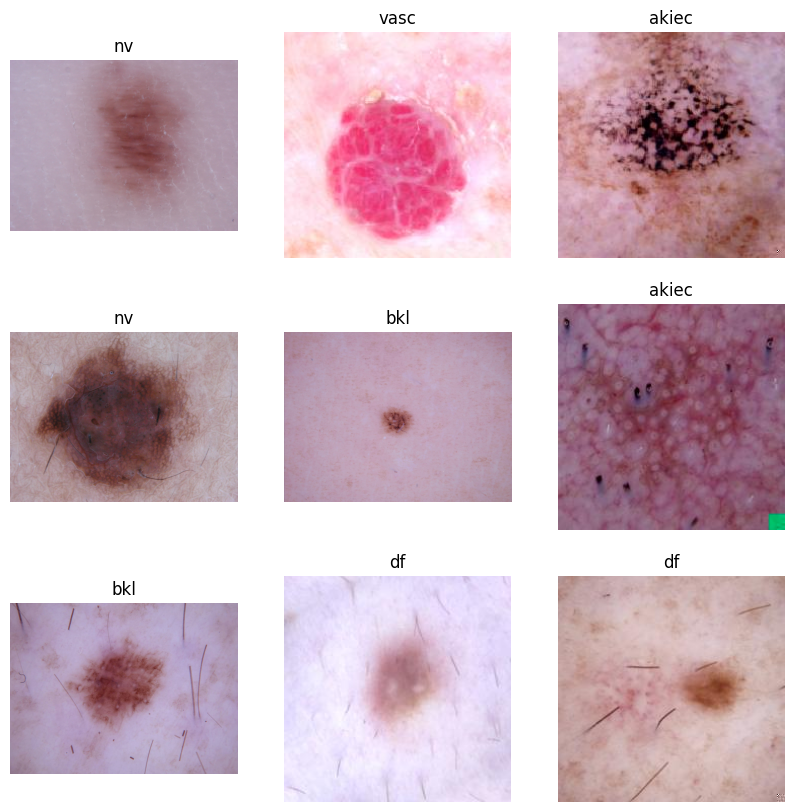

In [11]:
# Get a random sample of 9 images from the balanced_train_df
sample_df = balanced_train_df.sample(n=9, random_state=543)

# Create a list of image paths from the "image_path" column
image_paths = sample_df['image_path'].tolist()

# Create a list of image labels from the "dx" column
image_labels = sample_df['dx'].tolist()

# Load and plot the images without imagehelper
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()
for i, image_path in enumerate(image_paths):
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(image_labels[i])
    axes[i].axis('off')




## Saving Test, Validation and Training data to csv

In [12]:
balanced_train_df.to_csv('../data/processed/train_from_Metadata_processed.csv', index=False)
balanced_validation_df.to_csv('../data/processed/validation_from_Metadata_processed.csv', index=False)
test_df.to_csv('../data/processed/test_from_Metadata_processed.csv', index=False)

# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* Tests have shown that adding a dropout layer to the architecture, batch size of 16 as well as regularization increased the models performance. This is included in this model as well as setting model checkpoints.
* Thoughts on model checkpoints:
  * model.evaluate() in Keras uses the weights of the model at the time the method is called. So if you train a model for 20 epochs and call model.evaluate() immediately after training without making any further changes to the weights, then it will use the weights from the last, 20th epoch.
  * However, if you use a ModelCheckpoint with save_best_only=True during training, then the model's weights will only be saved if a particular metric (such as validation accuracy) improves. If you load these best weights into your model after training and then call model.evaluate(), the weights of the epoch with the best results will be used.
  * In summary, model.evaluate() always uses the current weights of the model. It is up to you to determine which weights are loaded in the model at which point in time. This is why we should use ModelCheckpoint with save_best_only=True to evaluate the *best* model.
* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images
* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.utils import class_weight


sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 25

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"
FILEPATH_MODELS = "../models/"

MODEL_NAME = 'Resnet50_tertiary_new_setup' # please adapt according to your changes using _ and - instead of " "

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 16 # Adapted according to findings

### Loading (augmented) metadata as test, train, validation from files

In [ ]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [ ]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

#### Data Image generator for Train and Validation

In [ ]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

### Control: Show some images from the train data set after preprocessing

In [ ]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [ ]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

In [ ]:
show_image_samples(train_data_generator)

## ResNet50 Setup


### Model architecture

In [ ]:
# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=l2(0.1)
           )(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
  
x = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(x)    

x = Dropout(0.5)(x)                                                 

x= Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.1))(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name=MODEL_NAME)

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9), 
    loss='categorical_crossentropy',
    metrics=['accuracy', mh.f1_score, Recall(name='recall')])

# Print model summary
#model.summary()

### Callback functions

#### Learning rate scheduler for model compilation

In [ ]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.001  # Initial learning rate
    target_lr = 0.0001  # Target learning rate for warmup
    warmup_epochs = 10  # Number of epochs for warmup
    drop = 0.8  # Learning rate drop factor
    epochs_drop = 4  # Number of epochs after which learning rate will drop

    #During the first 10 epochs, the learning rate will gradually increase from a very low value to the target warmup value (target_lr). 
    #After the warmup phase, the original learning rate schedule takes over.

    # Warmup phase
    if epoch < warmup_epochs: 
        return initial_lr + (target_lr - initial_lr) * epoch / warmup_epochs
    # After warmup, use the original schedule
    else:
        return initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))


# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Early stopping

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=8,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

#### Model checkpoint

In [ ]:
timestamp = datetime.now()

best_weights_checkpoint = ModelCheckpoint(
    filepath = f'{FILEPATH_MODELS}model_best-epoch_{timestamp}.h5', 
    save_best_only=True, 
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1
)

### Class weights 

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

## Model Training

In [ ]:
# Train the model
history = model.fit(
    train_data_generator,       # Training data generator
    epochs=NUM_EPOCHS,          # Number of training epochs
    verbose=1,                  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,      # Batch size for training
    callbacks=[
        lr_scheduler, 
        early_stopping,
        best_weights_checkpoint],
    validation_split=0.0,       # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,               # Shuffle the training data before each epoch
    sample_weight=None,         # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,            # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,       # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,      # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,          # Frequency to validate the model on the validation set
    max_queue_size=10,          # Maximum size of the generator queue
    workers=-1,                 # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False   # Use multiprocessing for data generation (True or False)
)

## Plotting accuracy and loss of train and validation set

#### Plotting Accuracy  of train and validation set

In [ ]:
# plotting accuracy of train and validation
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

In [ ]:
# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

In [ ]:
# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['recall'],  label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
timestamp = datetime.now()
model_path = f"{FILEPATH_MODELS}model_last-epoch_{timestamp}.h5"
model.save(model_path)

## Optional: Continue training 

In [ ]:
# Continue training for another 10 epochs
additional_epochs = 10
continue_training = False

if continue_training:
    history_continued = model.fit(
        train_data_generator,
        steps_per_epoch=None,
        epochs=NUM_EPOCHS + additional_epochs,
        initial_epoch=NUM_EPOCHS,  # start from the epoch after your last training session
        validation_data=validation_generator)


In [ ]:
if continue_training:
    mh.model_plot_accuracy(history_continued)

In [ ]:
if continue_training:
    mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

In [ ]:
if continue_training:
    timestamp = datetime.now()
    model_path = f"../models/model_last-epoch_{timestamp}.h5.h5"
    model.save(model_path)